# Channel Order Brute Force Search

This notebook determines the proper channel order of the antennas by testing all 24 possible permutations of a 4-element UCA and finding which gives the best raw MUSIC performance.

## Goal
The physical antennas may not be connected to channels 0, 1, 2, 3 in the order that matches the assumed UCA geometry. We'll brute-force all permutations to find the correct mapping.

## 1. Setup and Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from itertools import permutations
import os

# doa_py library
from doa_py.arrays import UniformCircularArray
from doa_py.algorithm.music_based import music

# Import shared constants
from constants import CHANNEL_ORDER, RADIUS, FREQ, WAVELENGTH, C, DATA_DIR

# Plot settings
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

print("Setup complete!")
print(f"Using channel order from constants.py: {CHANNEL_ORDER}")

## 2. Data Loading Functions

In [ ]:
def load_cs16(filepath):
    """Load a .cs16 file and return complex IQ samples."""
    raw = np.fromfile(filepath, dtype=np.int16)
    # Interleaved I, Q -> complex
    iq = raw[0::2] + 1j * raw[1::2]
    return iq

def load_measurement(base_dir, angle, channel_order=None):
    """Load all 4 channels for a given angle measurement.
    
    If channel_order is provided, reorders channels accordingly.
    """
    if channel_order is None:
        channel_order = CHANNEL_ORDER  # Use correct order from constants
    
    data_dir = os.path.join(base_dir, f"{angle}deg")
    channels = []
    for i in channel_order:
        filepath = os.path.join(data_dir, f"channel-{i}.cs16")
        channels.append(load_cs16(filepath))
    return np.vstack(channels)  # Shape: (4, num_samples)

def load_measurement_permuted(base_dir, angle, channel_order):
    """Load all 4 channels with a specific channel ordering.
    
    channel_order: tuple like (0, 1, 2, 3) or (2, 3, 0, 1) etc.
    This reorders which physical channel maps to which array element position.
    """
    data_dir = os.path.join(base_dir, f"{angle}deg")
    channels = []
    for i in channel_order:
        filepath = os.path.join(data_dir, f"channel-{i}.cs16")
        channels.append(load_cs16(filepath))
    return np.vstack(channels)  # Shape: (4, num_samples)

# Use DATA_DIR from constants (prepend ../data/ for notebook path)
DATA_PATH = f"../data/{DATA_DIR}"

# Test loading one measurement with correct channel order
X = load_measurement(DATA_PATH, 45)
print(f"Loaded data shape: {X.shape}")
print(f"Samples per channel: {X.shape[1]:,}")
print(f"Using channel order: {CHANNEL_ORDER}")

## 3. Array Geometry

In [ ]:
# Array parameters from constants.py
print("=== Array Geometry ===")
print(f"Radius: {RADIUS * 1000:.1f} mm")
print(f"Frequency: {FREQ / 1e9:.2f} GHz")
print(f"Wavelength: {WAVELENGTH * 1000:.1f} mm")
print(f"Array aperture: {2 * RADIUS / WAVELENGTH:.3f} wavelengths")
print(f"Correct channel order: {CHANNEL_ORDER}")

# Create the UCA using doa_py
uca = UniformCircularArray(m=4, r=RADIUS)

# Visualize the array with element labels
positions = uca.array_position
plt.figure(figsize=(6, 6))
plt.scatter(positions[:, 0] * 1000, positions[:, 1] * 1000, s=200, c='blue', marker='o')
for i, (x, y, z) in enumerate(positions):
    plt.annotate(f'Element {i}\n(ch-{CHANNEL_ORDER[i]})', (x * 1000 + 2, y * 1000 + 2), fontsize=10)

# Draw the circle
theta = np.linspace(0, 2 * np.pi, 100)
plt.plot(RADIUS * 1000 * np.cos(theta), RADIUS * 1000 * np.sin(theta), 'k--', alpha=0.5)

plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title(f'4-Element UCA Geometry\nChannel order: {CHANNEL_ORDER}')
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()

# Show element positions in degrees with channel mapping
print("\nElement positions with channel mapping:")
for i, (x, y, z) in enumerate(positions):
    angle_deg = np.rad2deg(np.arctan2(y, x)) % 360
    print(f"  Element {i} (channel-{CHANNEL_ORDER[i]}.cs16): {angle_deg:.0f}° on circle")

## 4. Narrowband Signal Extraction

In [23]:
def extract_tone_snapshots(X, n_snapshots=1024, fft_size=1024):
    """
    Extract narrowband snapshots at the tone frequency.
    
    Uses short-time FFT to get multiple snapshots at the tone bin.
    """
    n_channels, n_samples = X.shape
    
    # Find the tone bin
    fft_full = fft(X[0])
    peak_idx = np.argmax(np.abs(fft_full[1:n_samples//2])) + 1
    
    # Normalize peak_idx to fft_size
    norm_freq = peak_idx / n_samples
    tone_bin = int(norm_freq * fft_size)
    
    # Extract snapshots using STFT
    snapshots = []
    hop = fft_size // 2
    
    for start in range(0, n_samples - fft_size, hop):
        if len(snapshots) >= n_snapshots:
            break
        segment = X[:, start:start + fft_size]
        fft_seg = fft(segment, axis=1)
        snapshot = fft_seg[:, tone_bin]
        snapshots.append(snapshot)
    
    return np.array(snapshots).T  # Shape: (n_channels, n_snapshots)

# Test extraction
snapshots = extract_tone_snapshots(X, n_snapshots=256)
print(f"Extracted snapshots shape: {snapshots.shape}")

Extracted snapshots shape: (4, 256)


## 5. Raw MUSIC Estimation

In [24]:
def estimate_doa_music(X, uca, freq, angle_grids, n_snapshots=256):
    """
    Estimate DOA using raw MUSIC algorithm.
    Returns (estimated_angle, spectrum)
    """
    # Extract narrowband snapshots
    snapshots = extract_tone_snapshots(X, n_snapshots=n_snapshots)
    
    # MUSIC spectrum
    spectrum = music(
        received_data=snapshots,
        num_signal=1,
        array=uca,
        signal_fre=freq,
        angle_grids=angle_grids,
        unit="deg"
    )
    
    estimated_angle = angle_grids[np.argmax(spectrum)]
    return estimated_angle, spectrum

def circular_error(est, true):
    """Calculate error handling wraparound at +/-180."""
    err = est - true
    while err > 180: err -= 360
    while err < -180: err += 360
    return err

# Test on one angle with default channel order
angle_grids = np.arange(-180, 180, 1)
est, spectrum = estimate_doa_music(X, uca, FREQ, angle_grids)
print(f"True: 45°, Estimated: {est}°, Error: {circular_error(est, 45)}°")

True: 45°, Estimated: 60°, Error: 15°


## 6. Brute Force Channel Order Search

With 4 channels, there are 4! = 24 possible permutations. We'll test each one against a set of test angles and find which permutation gives the lowest RMSE.

In [25]:
# Generate all 24 permutations
all_permutations = list(permutations([0, 1, 2, 3]))
print(f"Total permutations to test: {len(all_permutations)}")
print("\nFirst 5 permutations:")
for p in all_permutations[:5]:
    print(f"  {p}")

Total permutations to test: 24

First 5 permutations:
  (0, 1, 2, 3)
  (0, 1, 3, 2)
  (0, 2, 1, 3)
  (0, 2, 3, 1)
  (0, 3, 1, 2)


In [26]:
# Test angles - use a subset for faster iteration
TEST_ANGLES = list(range(0, 360, 15))  # Every 15 degrees
print(f"Testing on {len(TEST_ANGLES)} angles: {TEST_ANGLES}")

Testing on 24 angles: [0, 15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 165, 180, 195, 210, 225, 240, 255, 270, 285, 300, 315, 330, 345]


In [ ]:
def evaluate_permutation(channel_order, test_angles, verbose=False):
    """
    Evaluate a channel permutation by computing RMSE over test angles.
    """
    errors = []
    
    for true_angle in test_angles:
        try:
            # Load with permuted channel order
            X = load_measurement_permuted(DATA_PATH, true_angle, channel_order)
            
            # Estimate DOA
            est, _ = estimate_doa_music(X, uca, FREQ, angle_grids)
            
            # Convert true angle to [-180, 180) for comparison
            true_adj = true_angle if true_angle <= 180 else true_angle - 360
            
            err = circular_error(est, true_adj)
            errors.append(err)
            
            if verbose:
                print(f"  {true_angle}° -> est: {est}°, err: {err:.1f}°")
                
        except Exception as e:
            if verbose:
                print(f"  {true_angle}°: ERROR - {e}")
    
    errors = np.array(errors)
    rmse = np.sqrt(np.mean(errors**2))
    mean_err = np.mean(errors)
    
    return rmse, mean_err, errors

# Quick test on the correct channel order from constants
print(f"Testing correct channel order {CHANNEL_ORDER}:")
rmse, mean_err, _ = evaluate_permutation(CHANNEL_ORDER, TEST_ANGLES[:4], verbose=True)
print(f"\nRMSE: {rmse:.2f}°, Mean error: {mean_err:.2f}°")

In [28]:
# Brute force search over all permutations
print("="*60)
print("BRUTE FORCE CHANNEL ORDER SEARCH")
print("="*60)
print(f"Testing {len(all_permutations)} permutations on {len(TEST_ANGLES)} angles...\n")

results = []

for i, perm in enumerate(all_permutations):
    rmse, mean_err, errors = evaluate_permutation(perm, TEST_ANGLES)
    results.append({
        'permutation': perm,
        'rmse': rmse,
        'mean_error': mean_err,
        'max_error': np.max(np.abs(errors)),
        'errors': errors
    })
    print(f"[{i+1:2d}/24] {perm} -> RMSE: {rmse:6.2f}°, Mean: {mean_err:+6.2f}°, Max: {np.max(np.abs(errors)):6.2f}°")

print("\nSearch complete!")

BRUTE FORCE CHANNEL ORDER SEARCH
Testing 24 permutations on 24 angles...

[ 1/24] (0, 1, 2, 3) -> RMSE:  51.95°, Mean: +31.50°, Max: 148.00°
[ 2/24] (0, 1, 3, 2) -> RMSE:  77.34°, Mean: +32.46°, Max: 149.00°
[ 3/24] (0, 2, 1, 3) -> RMSE:  67.30°, Mean: -22.75°, Max: 141.00°
[ 4/24] (0, 2, 3, 1) -> RMSE: 100.66°, Mean: -17.46°, Max: 178.00°
[ 5/24] (0, 3, 1, 2) -> RMSE: 128.80°, Mean: +52.75°, Max: 173.00°
[ 6/24] (0, 3, 2, 1) -> RMSE: 104.92°, Mean: +13.50°, Max: 179.00°
[ 7/24] (1, 0, 2, 3) -> RMSE:  91.48°, Mean: -17.46°, Max: 171.00°
[ 8/24] (1, 0, 3, 2) -> RMSE: 108.85°, Mean:  -1.50°, Max: 179.00°
[ 9/24] (1, 2, 0, 3) -> RMSE:  78.80°, Mean: -22.25°, Max: 168.00°
[10/24] (1, 2, 3, 0) -> RMSE:  71.62°, Mean: -58.50°, Max: 118.00°
[11/24] (1, 3, 0, 2) -> RMSE: 132.81°, Mean:  +7.25°, Max: 179.00°
[12/24] (1, 3, 2, 0) -> RMSE:  90.77°, Mean: -57.54°, Max: 173.00°
[13/24] (2, 0, 1, 3) -> RMSE: 112.93°, Mean: +17.46°, Max: 170.00°
[14/24] (2, 0, 3, 1) -> RMSE: 123.99°, Mean: -52.25°, M

In [29]:
# Sort by RMSE and show best results
results_sorted = sorted(results, key=lambda x: x['rmse'])

print("="*60)
print("TOP 5 CHANNEL ORDERINGS (by RMSE)")
print("="*60)
for i, r in enumerate(results_sorted[:5]):
    print(f"\n#{i+1}: {r['permutation']}")
    print(f"    RMSE: {r['rmse']:.2f}°")
    print(f"    Mean error: {r['mean_error']:.2f}°")
    print(f"    Max |error|: {r['max_error']:.2f}°")

print("\n" + "="*60)
print("WORST 3 CHANNEL ORDERINGS")
print("="*60)
for i, r in enumerate(results_sorted[-3:]):
    print(f"\n#{24-2+i}: {r['permutation']}")
    print(f"    RMSE: {r['rmse']:.2f}°")

TOP 5 CHANNEL ORDERINGS (by RMSE)

#1: (0, 1, 2, 3)
    RMSE: 51.95°
    Mean error: 31.50°
    Max |error|: 148.00°

#2: (0, 2, 1, 3)
    RMSE: 67.30°
    Mean error: -22.75°
    Max |error|: 141.00°

#3: (1, 2, 3, 0)
    RMSE: 71.62°
    Mean error: -58.50°
    Max |error|: 118.00°

#4: (3, 1, 2, 0)
    RMSE: 75.99°
    Mean error: 22.75°
    Max |error|: 157.00°

#5: (0, 1, 3, 2)
    RMSE: 77.34°
    Mean error: 32.46°
    Max |error|: 149.00°

WORST 3 CHANNEL ORDERINGS

#22: (0, 3, 1, 2)
    RMSE: 128.80°

#23: (1, 3, 0, 2)
    RMSE: 132.81°

#24: (2, 3, 0, 1)
    RMSE: 145.84°


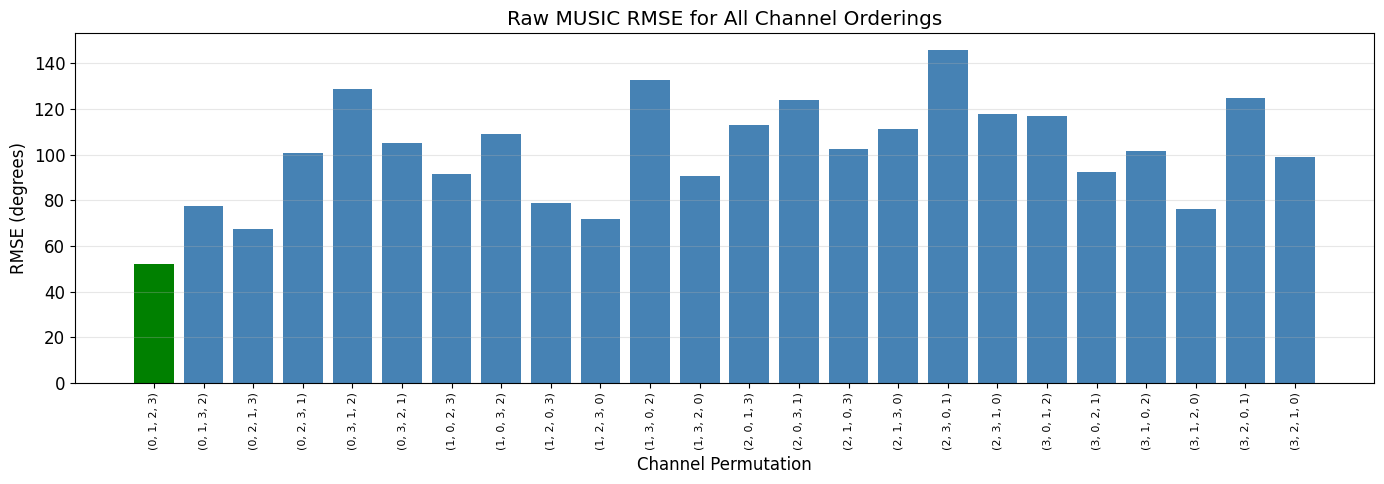


Best permutation: (0, 1, 2, 3) with RMSE = 51.95°


In [30]:
# Visualize RMSE for all permutations
plt.figure(figsize=(14, 5))

perms = [str(r['permutation']) for r in results]
rmses = [r['rmse'] for r in results]

colors = ['green' if r == min(rmses) else 'steelblue' for r in rmses]

plt.bar(range(len(perms)), rmses, color=colors)
plt.xticks(range(len(perms)), perms, rotation=90, fontsize=8)
plt.xlabel('Channel Permutation')
plt.ylabel('RMSE (degrees)')
plt.title('Raw MUSIC RMSE for All Channel Orderings')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

best = results_sorted[0]
print(f"\nBest permutation: {best['permutation']} with RMSE = {best['rmse']:.2f}°")

## 7. Detailed Analysis of Best Permutation

In [31]:
# Get the best permutation
BEST_ORDER = results_sorted[0]['permutation']
print(f"Best channel order: {BEST_ORDER}")
print(f"\nThis means:")
for i, ch in enumerate(BEST_ORDER):
    pos_angle = np.rad2deg(np.arctan2(positions[i, 1], positions[i, 0])) % 360
    print(f"  Physical channel-{ch}.cs16 -> Array element {i} (at {pos_angle:.0f}° on circle)")

Best channel order: (0, 1, 2, 3)

This means:
  Physical channel-0.cs16 -> Array element 0 (at 0° on circle)
  Physical channel-1.cs16 -> Array element 1 (at 90° on circle)
  Physical channel-2.cs16 -> Array element 2 (at 180° on circle)
  Physical channel-3.cs16 -> Array element 3 (at 270° on circle)


In [ ]:
# Evaluate on ALL angles (not just test set) using correct order
ALL_ANGLES = list(range(0, 360, 5))  # Every 5 degrees
BEST_ORDER = tuple(CHANNEL_ORDER)  # Use correct order from constants
print(f"Evaluating correct order {BEST_ORDER} on {len(ALL_ANGLES)} angles...")

true_angles = []
estimated_angles = []
errors = []

for true_angle in ALL_ANGLES:
    try:
        X = load_measurement_permuted(DATA_PATH, true_angle, BEST_ORDER)
        est, _ = estimate_doa_music(X, uca, FREQ, angle_grids)
        
        true_adj = true_angle if true_angle <= 180 else true_angle - 360
        err = circular_error(est, true_adj)
        
        true_angles.append(true_angle)
        estimated_angles.append(est)
        errors.append(err)
    except Exception as e:
        print(f"Error at {true_angle}°: {e}")

errors = np.array(errors)
rmse_full = np.sqrt(np.mean(errors**2))

print(f"\nResults with correct order {BEST_ORDER}:")
print(f"  RMSE: {rmse_full:.2f}°")
print(f"  Mean error: {np.mean(errors):.2f}°")
print(f"  Max |error|: {np.max(np.abs(errors)):.2f}°")
print(f"  90th percentile |error|: {np.percentile(np.abs(errors), 90):.2f}°")

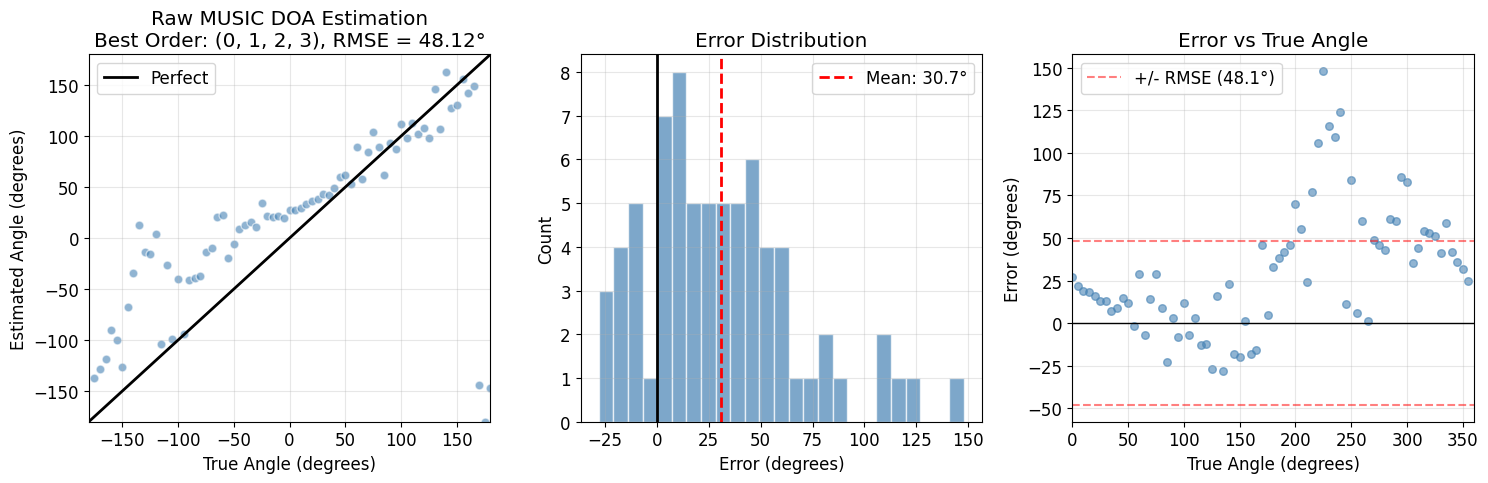

In [33]:
# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Estimated vs True
ax = axes[0]
true_adj = [t if t <= 180 else t - 360 for t in true_angles]
ax.plot([-180, 180], [-180, 180], 'k-', linewidth=2, label='Perfect')
ax.scatter(true_adj, estimated_angles, alpha=0.6, s=40, c='steelblue', edgecolors='white')
ax.set_xlabel('True Angle (degrees)')
ax.set_ylabel('Estimated Angle (degrees)')
ax.set_title(f'Raw MUSIC DOA Estimation\nBest Order: {BEST_ORDER}, RMSE = {rmse_full:.2f}°')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(-180, 180)
ax.set_ylim(-180, 180)

# Plot 2: Error distribution
ax = axes[1]
ax.hist(errors, bins=25, color='steelblue', edgecolor='white', alpha=0.7)
ax.axvline(0, color='black', linestyle='-', linewidth=2)
ax.axvline(np.mean(errors), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(errors):.1f}°')
ax.set_xlabel('Error (degrees)')
ax.set_ylabel('Count')
ax.set_title('Error Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Error vs True angle
ax = axes[2]
ax.scatter(true_angles, errors, alpha=0.6, s=30, c='steelblue')
ax.axhline(0, color='black', linestyle='-', linewidth=1)
ax.axhline(rmse_full, color='red', linestyle='--', alpha=0.5, label=f'+/- RMSE ({rmse_full:.1f}°)')
ax.axhline(-rmse_full, color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('True Angle (degrees)')
ax.set_ylabel('Error (degrees)')
ax.set_title('Error vs True Angle')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 360)

plt.tight_layout()
plt.show()

## 8. Compare Best vs Default Order

In [ ]:
# Evaluate default (wrong) order on all angles for comparison
DEFAULT_ORDER = (0, 1, 2, 3)

errors_default = []
for true_angle in ALL_ANGLES:
    try:
        X = load_measurement_permuted(DATA_PATH, true_angle, DEFAULT_ORDER)
        est, _ = estimate_doa_music(X, uca, FREQ, angle_grids)
        true_adj = true_angle if true_angle <= 180 else true_angle - 360
        err = circular_error(est, true_adj)
        errors_default.append(err)
    except:
        pass

errors_default = np.array(errors_default)
rmse_default = np.sqrt(np.mean(errors_default**2))

print("="*50)
print("COMPARISON: DEFAULT vs CORRECT CHANNEL ORDER")
print("="*50)
print(f"\nDefault (wrong) order {DEFAULT_ORDER}:")
print(f"  RMSE: {rmse_default:.2f}°")
print(f"  Mean error: {np.mean(errors_default):.2f}°")

print(f"\nCorrect order {BEST_ORDER} (from constants.py):")
print(f"  RMSE: {rmse_full:.2f}°")
print(f"  Mean error: {np.mean(errors):.2f}°")

improvement = (rmse_default - rmse_full) / rmse_default * 100
print(f"\nImprovement: {improvement:.1f}%")
print("="*50)

ValueError: x and y must be the same size

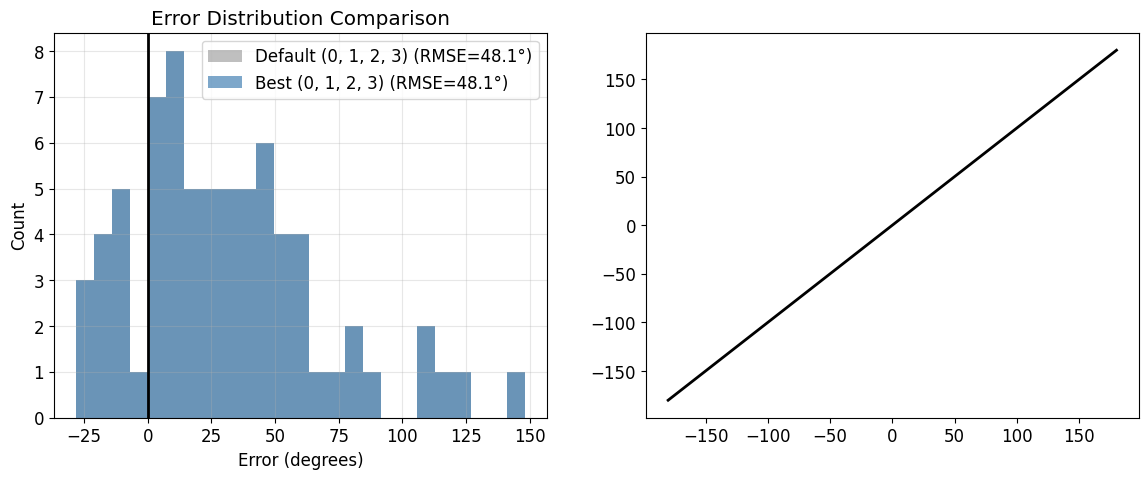

In [35]:
# Visual comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Error distributions
ax = axes[0]
ax.hist(errors_default, bins=25, alpha=0.5, color='gray', label=f'Default {DEFAULT_ORDER} (RMSE={rmse_default:.1f}°)')
ax.hist(errors, bins=25, alpha=0.7, color='steelblue', label=f'Best {BEST_ORDER} (RMSE={rmse_full:.1f}°)')
ax.axvline(0, color='black', linestyle='-', linewidth=2)
ax.set_xlabel('Error (degrees)')
ax.set_ylabel('Count')
ax.set_title('Error Distribution Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# Side by side scatter
ax = axes[1]
ax.plot([-180, 180], [-180, 180], 'k-', linewidth=2, label='Perfect')
# We'd need to store estimated angles for default too, skipping for now
ax.scatter(true_adj, estimated_angles, alpha=0.7, s=40, c='steelblue', label=f'Best: {BEST_ORDER}')
ax.set_xlabel('True Angle (degrees)')
ax.set_ylabel('Estimated Angle (degrees)')
ax.set_title(f'DOA Estimation with Best Channel Order')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(-180, 180)
ax.set_ylim(-180, 180)

plt.tight_layout()
plt.show()

## 9. Summary

In [ ]:
print("="*60)
print("SUMMARY: CHANNEL ORDER BRUTE FORCE SEARCH")
print("="*60)
print(f"\nBest channel order found: {BEST_ORDER}")
print(f"")
print(f"Physical to logical mapping:")
for i, ch in enumerate(BEST_ORDER):
    pos_angle = np.rad2deg(np.arctan2(positions[i, 1], positions[i, 0])) % 360
    print(f"  channel-{ch}.cs16 -> Element {i} ({pos_angle:.0f}° on UCA)")
print(f"")
print(f"Raw MUSIC Performance (no calibration):")
print(f"  RMSE: {rmse_full:.2f}°")
print(f"  Mean error: {np.mean(errors):.2f}° (systematic offset)")
print(f"  Max |error|: {np.max(np.abs(errors)):.2f}°")
print(f"")
print(f"Improvement over default order: {improvement:.1f}%")
print("="*60)

## 10. MUSIC Spectrum Visualization

In [ ]:
# Show MUSIC spectrum for a few example angles with correct order
example_angles = [0, 45, 90, 135, 180, 225, 270, 315]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, true_angle in enumerate(example_angles):
    X = load_measurement_permuted(DATA_PATH, true_angle, BEST_ORDER)
    est, spectrum = estimate_doa_music(X, uca, FREQ, angle_grids)
    
    ax = axes[i]
    spectrum_db = 10 * np.log10(spectrum / np.max(spectrum))
    ax.plot(angle_grids, spectrum_db, 'b-', linewidth=1.5)
    
    true_adj = true_angle if true_angle <= 180 else true_angle - 360
    ax.axvline(true_adj, color='g', linestyle='--', linewidth=2, label=f'True: {true_adj}°')
    ax.axvline(est, color='r', linestyle=':', linewidth=2, label=f'Est: {est}°')
    
    err = circular_error(est, true_adj)
    ax.set_title(f'Measurement at {true_angle}° (err: {err:.0f}°)')
    ax.set_xlabel('Angle (deg)')
    ax.set_ylabel('MUSIC (dB)')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-180, 180)
    ax.set_ylim(-30, 5)

plt.suptitle(f'MUSIC Spectra with Correct Channel Order {BEST_ORDER}', fontsize=14)
plt.tight_layout()
plt.show()